This tutorial is about
- Work with complex numbers in quantax
- Solve triangular J1-J2 model
- Impose prior sign structure in NQS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import quantax as qtx
from IPython.display import clear_output

# Computations outside variational ansatz are performed with complex128
# The variational parameters are still default to float32
qtx.set_default_dtype(jnp.complex128)

lattice = qtx.sites.Triangular(6, Nparticle=(18, 18)) # 6x6 triangular lattice
N = lattice.N

In [ ]:
from quantax.symmetry import SpinInverse, D6

# Triangular Heisenberg model with nearest neighbor interaction
H = qtx.operator.Heisenberg()
# ED is difficult for the large lattice. The GS energy is -74.241280268

# Network with real parameters and complex outputs
# the activation in the last layer is z = e^(x1 + 1j * x2)
# for details see https://journals.aps.org/prb/abstract/10.1103/PhysRevB.108.054410
model = qtx.model.ResSum(2, 8, 3)

# Sign network with Neel-120° order
# for details see https://journals.aps.org/prb/abstract/10.1103/PhysRevB.95.035141
sign_net = qtx.model.Neel120()

# The NQS is a combination of the network and a prior sign structure
state = qtx.state.Variational(
    model,
    max_parallel=32768,
    factor=sign_net,
)

# sampler contains spin exchanges between nearest neighbors
sampler = qtx.sampler.SpinExchange(state, 1000)
optimizer = qtx.optimizer.SR(state, H)

AttributeError: module 'quantax.sampler' has no attribute 'SpinExchange'

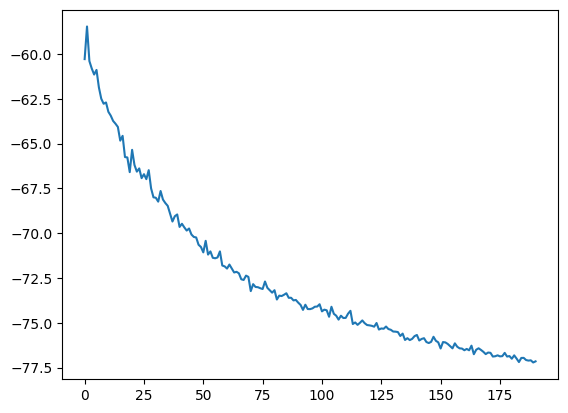

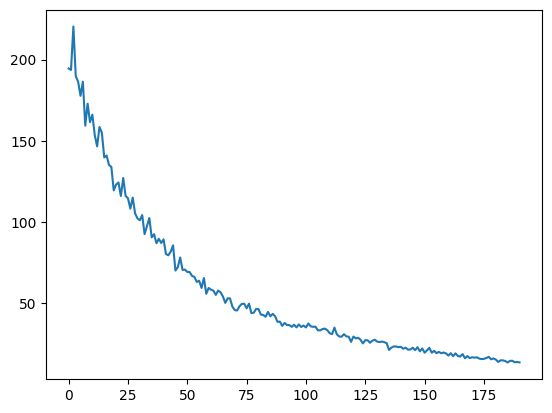

In [ ]:
energy_data = qtx.utils.DataTracer()
VarE_data = qtx.utils.DataTracer()

for i in range(200):
    samples = sampler.sweep()
    step = optimizer.get_step(samples)
    state.update(step * 1e-3)
    energy_data.append(optimizer.energy)
    VarE_data.append(optimizer.VarE)

    if i % 10 == 0:
        clear_output()
        energy_data.plot()
        plt.show()
        VarE_data.plot()
        plt.show()

In [ ]:
# symmetrize the trained NQS

symm = SpinInverse() + D6()

symm_state = qtx.state.Variational(
    state.model,
    symm=symm,
    max_parallel=32768,
    factor=sign_net,
)

sampler = qtx.sampler.SpinExchange(symm_state, 1000)
optimizer = qtx.optimizer.SR(symm_state, H)

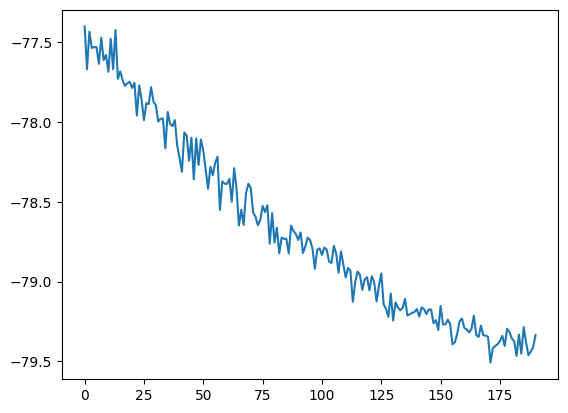

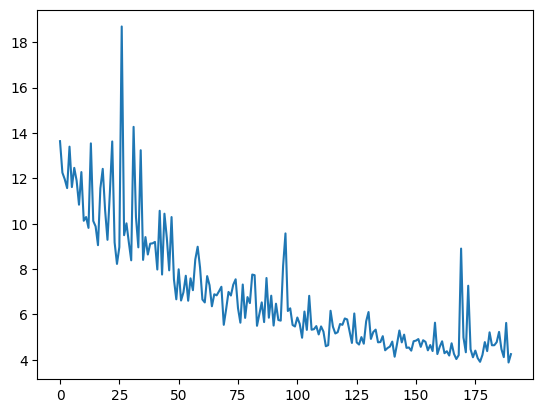

In [ ]:
energy_data = qtx.utils.DataTracer()
VarE_data = qtx.utils.DataTracer()

for i in range(200):
    samples = sampler.sweep()
    step = optimizer.get_step(samples)
    symm_state.update(step * 1e-3)
    energy_data.append(optimizer.energy)
    VarE_data.append(optimizer.VarE)

    if i % 10 == 0:
        clear_output()
        energy_data.plot()
        plt.show()
        VarE_data.plot()
        plt.show()

# The ground state energy should be -80.6937689612426.